In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Data were loaded and cleaned. The cleaning process included getting rid of the punctuation marks and converting the texts into lower case.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


In the original data, many categories are highly ralated. 59 categories are regrouped, forming larger categories. There are eventually 50 categories in total.

In [3]:
related_categories = pd.read_csv("related_categories.csv")
related_categories

,original,grouped
0,accessibility,equal_rights
1,addiction,substance_addiction
2,android-development,it_industry
3,art,cultural_topics
4,artificial-intelligence,datascience_ai
5,basic-income,political_topics
6,blockchain,finance_economy
7,business,business_marketing
8,cryptocurrency,finance_economy
9,cybersecurity,security


In [4]:
for i in related_categories.index:
    titles.category = titles.category.replace(*related_categories.loc[i])
    
titles.head()

,category,title
0,work_related,21 conversations a fun and easy game for team...
1,religion_spirituality,biblical porn at mars hill
2,equal_rights,cisgender is that a disease
3,equal_rights,call me nat love black cowboys and the frontie...
4,datascience_ai,can i train my model on your computer


20% of the data were held out for testing.

In [5]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.values
X_test = titles_test.title.values

y_train = titles_train.category.values
y_test = titles_test.category.values

In [6]:
import warnings
warnings.filterwarnings('ignore')

The theme labels were converted to one hot representations.

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

# Tokenization and vectorization

Use TF-IDF to perform bag-of-words vetorization.

We adopted the Penn Treebank Tokenizer. We did not want to include n-grams because it will significantly increase the size of the vocabulary. Terms that appear less than twice or occur in more than 10% of the docuemnts are rejected. This choice is made based on experience extracting features for a naive Bayes model.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

tokenizer = TreebankWordTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 1), stop_words='english', min_df=2, max_df=0.1)

XMatrix_train = vectorizer.fit_transform(X_train)
vocabulary = np.array(vectorizer.get_feature_names())

XMatrix_test = vectorizer.transform(X_test)

In [9]:
vocabularySize = vocabulary.size
print("Number of terms in the vocabulary: {}".format(vocabularySize))

Number of terms in the vocabulary: 22359


# Multilayer perceptron network

## 2 hidden layers, 256, 256

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from time import time
from keras.models import load_model

layer1 = Dense(256, activation="relu", input_dim=vocabularySize)
layer2 = Dense(256, activation="relu")
outputLayer = Dense(50, activation="softmax")
classifier = Sequential([layer1, layer2, outputLayer])
classifier.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=50, min_delta=1, verbose=2)
best_model_saving = ModelCheckpoint("MLP_best_model.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=2)

start_time = time()
history = classifier.fit(XMatrix_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(XMatrix_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier = load_model("MLP_best_model.h5")
_, train_accuracy = classifier.evaluate(XMatrix_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier.evaluate(XMatrix_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 101134 samples, validate on 25284 samples
Epoch 1/5000





 - 21s - loss: 3.5106 - acc: 0.1384 - val_loss: 3.0730 - val_acc: 0.3053

Epoch 00001: val_acc improved from -inf to 0.30525, saving model to MLP_best_model.h5
Epoch 2/5000
 - 20s - loss: 2.5708 - acc: 0.3987 - val_loss: 2.2991 - val_acc: 0.4284

Epoch 00002: val_acc improved from 0.30525 to 0.42841, saving model to MLP_best_model.h5
Epoch 3/5000
 - 21s - loss: 1.8788 - acc: 0.5300 - val_loss: 2.0495 - val_acc: 0.4861

Epoch 00003: val_acc improved from 0.42841 to 0.48612, saving model to MLP_best_model.h5
Epoch 4/5000
 - 21s - loss: 1.4663 - acc: 0.6259 - val_loss: 2.0259 - val_acc: 0.4909

Epoch 00004: val_acc improved from 0.48612 to 0.49094, saving model to MLP_best_model.h5
Epoch 5/5000
 - 20s - loss: 1.2199 - acc: 0.6795 - val_loss: 2.0822 - val_acc: 0.4853

Epoch 00005: val_acc did not improve from 0.49094
Epoc

 - 22s - loss: 0.1519 - acc: 0.9612 - val_loss: 4.7269 - val_acc: 0.4096

Epoch 00035: val_acc did not improve from 0.49094
Epoch 36/5000
 - 22s - loss: 0.1467 - acc: 0.9619 - val_loss: 4.7682 - val_acc: 0.4076

Epoch 00036: val_acc did not improve from 0.49094
Epoch 37/5000
 - 21s - loss: 0.1410 - acc: 0.9632 - val_loss: 4.8288 - val_acc: 0.4082

Epoch 00037: val_acc did not improve from 0.49094
Epoch 38/5000
 - 22s - loss: 0.1359 - acc: 0.9645 - val_loss: 4.8741 - val_acc: 0.4067

Epoch 00038: val_acc did not improve from 0.49094
Epoch 39/5000
 - 22s - loss: 0.1316 - acc: 0.9653 - val_loss: 4.9110 - val_acc: 0.4072

Epoch 00039: val_acc did not improve from 0.49094
Epoch 40/5000
 - 26s - loss: 0.1272 - acc: 0.9665 - val_loss: 4.9603 - val_acc: 0.4058

Epoch 00040: val_acc did not improve from 0.49094
Epoch 41/5000
 - 26s - loss: 0.1230 - acc: 0.9675 - val_loss: 4.9995 - val_acc: 0.4051

Epoch 00041: val_acc did not improve from 0.49094
Epoch 42/5000
 - 24s - loss: 0.1193 - acc: 0.968

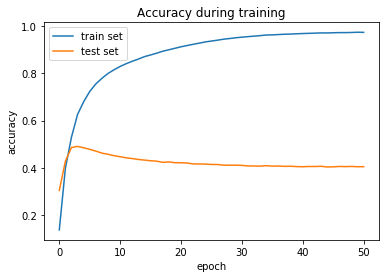

In [11]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history)

# Precision-recall

In [12]:
probability = classifier.predict_proba(XMatrix_test)
classList = integer_encoder.classes_

In [13]:
realLabel = np.equal(np.repeat(np.reshape(y_test, (-1, 1)), len(classList), axis=1), np.repeat(np.reshape(classList, (1, -1)), len(y_test), axis=0))
thresholds = np.arange(0, 1.001, 0.001)
precision = np.zeros((len(thresholds), len(classList)))
recall = np.zeros((len(thresholds), len(classList)))

for i, threshold in enumerate(thresholds):
    predictedLabel = probability >= threshold

    truePoz = (predictedLabel & realLabel).sum(axis = 0)
    falsePoz = (predictedLabel & (realLabel == False)).sum(axis = 0)
    falseNeg = ((predictedLabel == False) & realLabel).sum(axis = 0)

    precision[i, :] = truePoz / (truePoz + falsePoz)
    recall[i, :] = truePoz / (truePoz + falseNeg)
    
averagePrecision = np.nanmean(precision, axis=1)
averageRecall = np.nanmean(recall, axis=1)
minPrecision = np.nanmin(precision, axis=1)
maxPrecision = np.nanmax(precision, axis=1)

Text(0, 0.5, 'precision')

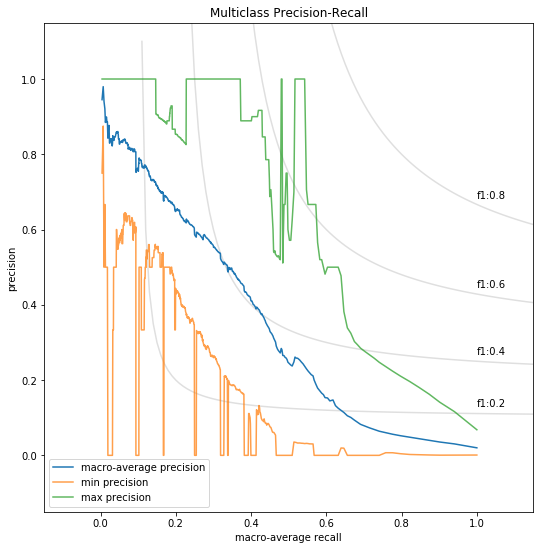

In [14]:
plt.figure(figsize=(9,9))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1.15, 115)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.25)
    plt.annotate('f1:{0:0.1f}'.format(f_score), xy=(1, y[100] + 0.02))

plt.plot(averageRecall, averagePrecision, label="macro-average precision")
plt.plot(averageRecall, minPrecision, label="min precision", alpha=0.75)
plt.plot(averageRecall, maxPrecision, label="max precision", alpha=0.75)

plt.xlim([-.15, 1.15])
plt.ylim([-.15, 1.15])
plt.gca().set_aspect('equal')
plt.legend(loc="lower left")
plt.title("Multiclass Precision-Recall")
plt.xlabel("macro-average recall")
plt.ylabel("precision")

In [15]:
maxProbability = probability.max(axis=1)
classifiedProportion = np.zeros(len(thresholds))
for i, threshold in enumerate(thresholds):
    classifiedProportion[i] = (maxProbability >= threshold).sum() / len(maxProbability)

Text(0.5, 1.0, 'Precision & Recall')

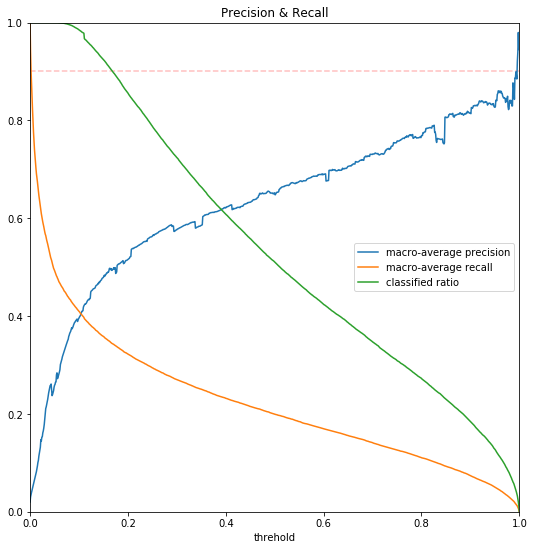

In [16]:
plt.figure(figsize=(9,9))

plt.axhline(0.9, color="red",linestyle='dashed', alpha=0.25)
plt.plot(thresholds, averagePrecision, label="macro-average precision")
plt.plot(thresholds, averageRecall, label="macro-average recall")
plt.plot(thresholds, classifiedProportion, label="classified ratio")

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal')
plt.legend(loc="center right")
plt.xlabel("threhold")
plt.title("Precision & Recall")

In [17]:
threshold90 = thresholds[averagePrecision >= 0.9].min()
recall90 = averageRecall[threshold90 == thresholds][0]
print("To reach a multiclass average precision more than 90%, the minimum threshold is " + str(threshold90) + "; the corresponding multiclass average recall is " + str(recall90) + ".")

To reach a multiclass average precision more than 90%, the minimum threshold is 0.996; the corresponding multiclass average recall is 0.011550798315129509.
